Import Libraries

In [3]:
import pandas as pd
import numpy as np
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

Load Hurricane Harvey Data

In [4]:
def load_data(train_path, dev_path, test_path):
    train_df = pd.read_csv(train_path, sep="\t")
    dev_df = pd.read_csv(dev_path, sep="\t")
    test_df = pd.read_csv(test_path, sep="\t")

    # Combine train data and dev data for better training
    train_df = pd.concat([train_df, dev_df], ignore_index=True)
    return train_df, test_df

train_path = "/content/hurricane_harvey_2017_train.tsv"
dev_path = "/content/hurricane_harvey_2017_dev.tsv"
test_path = "/content/hurricane_harvey_2017_test.tsv"

train_df, test_df = load_data(train_path, dev_path, test_path)

In [5]:
train_df

,tweet_id,tweet_text,class_label
0,903388763073720321,"Hurricane Harvey killed at least 38 people, bu...",injured_or_dead_people
1,901136425348759552,Harvey upped to Category 2 hurricane with 110+...,other_relevant_information
2,902853707607535616,A huge shoutout @TexasGuard for all the work y...,rescue_volunteering_or_donation_effort
3,902859729701044224,Our thoughts and prayers are with the people h...,sympathy_and_support
4,901405975856414720,Homes destroyed on Broadway St in Rockport. Pe...,infrastructure_and_utility_damage
...,...,...,...
7302,902877340191129600,"@realDonaldTrump Meanwhile, #FoxNews was turn ...",injured_or_dead_people
7303,903055122586054656,Latest from Natl Hurricane Center.. #Harvey is...,other_relevant_information
7304,902687457375907840,"As we prepare for a new school year, my prayer...",sympathy_and_support
7305,902606594021744640,Very upsetting to think of the children displa...,displaced_people_and_evacuations


In [6]:
test_df

,tweet_id,tweet_text,class_label
0,903458068217913345,Can you not use a tragedy that destroyed my co...,infrastructure_and_utility_damage
1,902656565852999680,"After #Harvey, we need to re-think the messagi...",caution_and_advice
2,901671671731560448,A second person was killed on Saturday as Harv...,injured_or_dead_people
3,903446990708723712,DETAILS: #Evacuation order issued for those wi...,displaced_people_and_evacuations
4,902657492966105088,Join us &amp; the @phoenixsaloon for a special...,rescue_volunteering_or_donation_effort
...,...,...,...
1800,903352997530542081,White House: 100000 homes affected by Hurrican...,infrastructure_and_utility_damage
1801,901750663574462464,Tampa News Severe storms and ‘suspected tornad...,infrastructure_and_utility_damage
1802,903762709367447556,We are donating 20% of ALL merch proceeds to H...,rescue_volunteering_or_donation_effort
1803,902638125490421760,Joey Baby opened his Lakewood Mega$hurch for 5...,other_relevant_information


ALL DATA

In [7]:
tweet_data = pd.concat([train_df, test_df], ignore_index=True)

In [8]:
tweet_data['class_label'].value_counts()

,count
class_label,
rescue_volunteering_or_donation_effort,2823
other_relevant_information,1767
infrastructure_and_utility_damage,1217
injured_or_dead_people,698
displaced_people_and_evacuations,688
sympathy_and_support,635
caution_and_advice,541
not_humanitarian,410
requests_or_urgent_needs,333


Data Preprocessing

In [9]:
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)
    text = re.sub(r"\@\w+|\#", "", text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = re.sub(r"\d+", "", text)
    return text.strip()

train_df["clean_text"] = train_df["tweet_text"].apply(clean_text)
test_df["clean_text"] = test_df["tweet_text"].apply(clean_text)

In [10]:
vectorizer = TfidfVectorizer(stop_words="english", max_features=5000)
X_train = vectorizer.fit_transform(train_df["clean_text"])
X_test = vectorizer.transform(test_df["clean_text"])

In [11]:
label_mapping = {label: idx for idx, label in enumerate(train_df["class_label"].unique())}
y_train = train_df["class_label"].map(label_mapping)
y_test = test_df["class_label"].map(label_mapping)

Define confusion matrix

In [12]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, model_name, class_labels):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)

    plt.xlabel("Predicted Labels", fontsize=10)
    plt.ylabel("Actual Labels", fontsize=10)
    plt.title(f"Confusion Matrix - {model_name}", fontsize=10)

    plt.xticks(rotation=90)
    plt.yticks(rotation=0)

    plt.show()

class_labels = list(label_mapping.keys())


In [13]:
def evaluate_model(y_true, y_pred, model_name):
    precision = precision_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    accuracy = accuracy_score(y_true, y_pred)
    print(f"\n{model_name} Evaluation:")
    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'F1 Score: {f1}')

    print("\n Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_labels))

Decision Tree

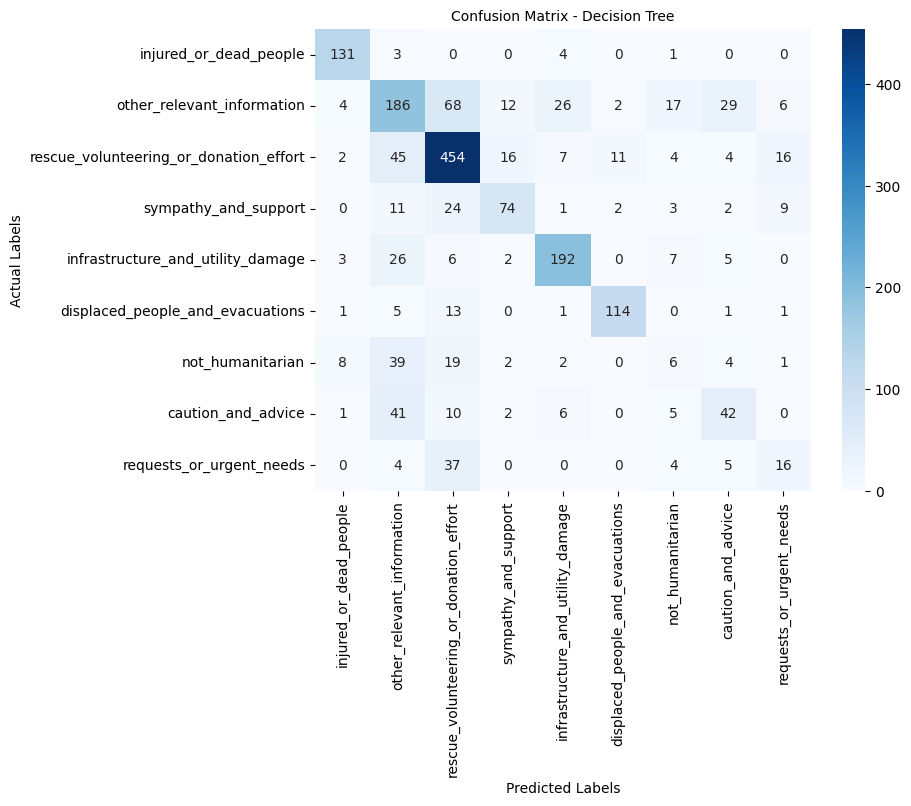


Decision Tree Evaluation:
Accuracy: 0.6731301939058172
Precision: 0.6566695438061017
F1 Score: 0.6629106038457746

 Classification Report:
                                        precision    recall  f1-score   support

                injured_or_dead_people       0.87      0.94      0.91       139
            other_relevant_information       0.52      0.53      0.52       350
rescue_volunteering_or_donation_effort       0.72      0.81      0.76       559
                  sympathy_and_support       0.69      0.59      0.63       126
     infrastructure_and_utility_damage       0.80      0.80      0.80       241
      displaced_people_and_evacuations       0.88      0.84      0.86       136
                      not_humanitarian       0.13      0.07      0.09        81
                    caution_and_advice       0.46      0.39      0.42       107
              requests_or_urgent_needs       0.33      0.24      0.28        66

                              accuracy                    

In [14]:
from sklearn.metrics import accuracy_score, classification_report, precision_score, f1_score, recall_score

dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
dt_preds = dt_model.predict(X_test)

plot_confusion_matrix(y_test, dt_preds, "Decision Tree", class_labels)
evaluate_model(y_test, dt_preds,"Decision Tree")


Random Forest

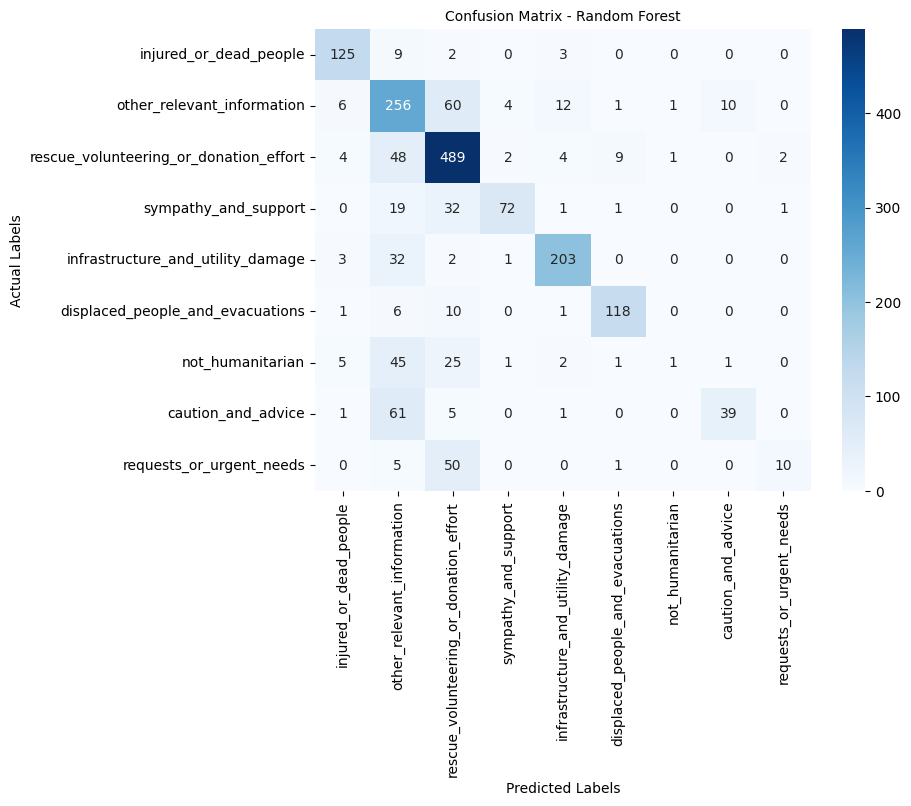


Random Forest Evaluation:
Accuracy: 0.7274238227146814
Precision: 0.7333648134524086
F1 Score: 0.7037075333229816

 Classification Report:
                                        precision    recall  f1-score   support

                injured_or_dead_people       0.86      0.90      0.88       139
            other_relevant_information       0.53      0.73      0.62       350
rescue_volunteering_or_donation_effort       0.72      0.87      0.79       559
                  sympathy_and_support       0.90      0.57      0.70       126
     infrastructure_and_utility_damage       0.89      0.84      0.87       241
      displaced_people_and_evacuations       0.90      0.87      0.88       136
                      not_humanitarian       0.33      0.01      0.02        81
                    caution_and_advice       0.78      0.36      0.50       107
              requests_or_urgent_needs       0.77      0.15      0.25        66

                              accuracy                    

In [15]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

plot_confusion_matrix(y_test, rf_preds, "Random Forest", class_labels)
evaluate_model(y_test, rf_preds,"Random Forest")

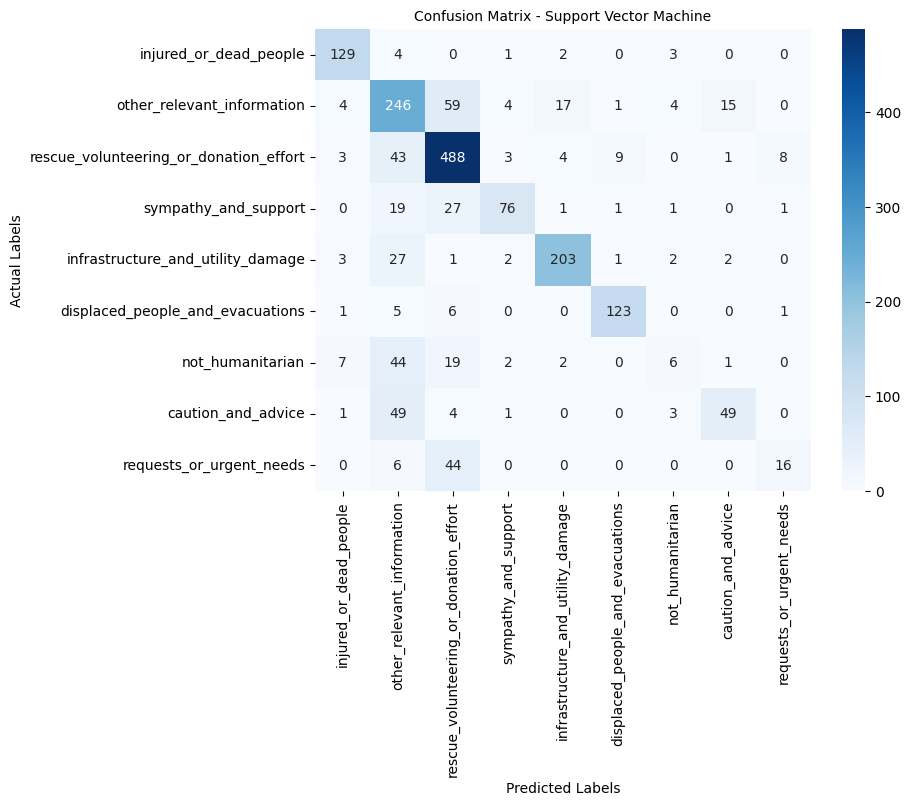


Support Vector Machine Evaluation:
Accuracy: 0.7401662049861496
Precision: 0.7340325859634961
F1 Score: 0.7243400452418072

 Classification Report:
                                        precision    recall  f1-score   support

                injured_or_dead_people       0.87      0.93      0.90       139
            other_relevant_information       0.56      0.70      0.62       350
rescue_volunteering_or_donation_effort       0.75      0.87      0.81       559
                  sympathy_and_support       0.85      0.60      0.71       126
     infrastructure_and_utility_damage       0.89      0.84      0.86       241
      displaced_people_and_evacuations       0.91      0.90      0.91       136
                      not_humanitarian       0.32      0.07      0.12        81
                    caution_and_advice       0.72      0.46      0.56       107
              requests_or_urgent_needs       0.62      0.24      0.35        66

                              accuracy           

In [16]:
svm_model = SVC(kernel="linear", random_state=42)
svm_model.fit(X_train, y_train)
svm_preds = svm_model.predict(X_test)

plot_confusion_matrix(y_test, svm_preds, "Support Vector Machine", class_labels)
evaluate_model(y_test, svm_preds,"Support Vector Machine")